In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib auto
#
import sys
if not '../' in sys.path: sys.path.insert(0, '../')


In [2]:
# standard imports, defs, etc.
#
import numpy
import scipy
import scipy.optimize
import pylab as plt
import random
import multiprocessing as mpp
#
import multiprocessing as mpp
#
import numpy
import math
import pylab as plt
import datetime as dtm
import time
#
import kalman_filters
#

##### A Few Notes and Caveats:
This is meant to be an instrucvive, development oriented notebook targeted towards an academically diverse audience, most of whom will likely lack much formal training in signal processing and statistics or probability theory. Thereofre, much of the prose, code, and comments are intended to express certain concepts in a langage and context that is more accessible to this audience -- I extend my apologies to any properly trained statisticians in the audience. To that end, there may be a mistake or two, particularly in the prose; comments and contributions are welcome.
##### Kalman Filter Code:
Kalman filter code is located alongside this notebook in the module:
kalman_filters.py

### Kalman Filter (Recursive, Markov Bayesian estimation)

Basic idea: compress the information contained in a sequence of data into a single measure of probability (scalar) for each point in a time series. The probability can be caluculated from a higher dimensional space, and then of course each point in a time series is expandet to a vector, $x_j \to [x_j, P_j]$. We also need probaility distributions for the (co)variance of $x_j$, or more generally, we need to define transformation matrices of the sort, $x_j = \hat A  \cdot \vec{x}_{j-1}$

We start with the basic Bayes statement:

\begin{equation}
P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}
\end{equation}

We can interpret this to mean that $A$ are the "best estimates" or "true value," and {B} are "the data."  The basic idea, then, is that the probability $P(B|A)$ is, "the probability of observing the data $x_j$ given the "true value" $<x>$. For our purposes, "the data" are the previous estimate (and its associated probability) and the current observation/measurement,

\begin{equation}
"the data" = \{ <x>_{j-1}, P_{j-1}, x_j \}
\end{equation}

\begin{equation}
P(<x>_j | <x>_{j-1},x_j) = \frac{[P_{j-1}  \cdot  P(<x>_j - x_j)] \cdot [P_{j-1} P(<x>_j - <x>_{j-1})]}{P_{j-1} \cdot P(<x>_{j-1} - x_j)}.
\end{equation}

To clarify a bit, "the data" include two points: the current observation and the previous expected value and its probability. For the first term $[P_{j-1}  \cdot  P(<x>_j - x_j)$, then,  $P_{j-1}$ represents the probability contribution from the previous step; the $P(<x>_j - x_j)$ part indicates the probability of the true value given the current observation.

Clearly one order of $P_{j-1}$ in the numerator cancels, yielding the fairly straightforward and intuitive (with respect to this being a Markov process and Bayes methods, where the probability distributions are determined based on the differences between expected and observed values). There are a lot of ways to understand this; in the above notation, we incorporate the Markov component into the Bayes framework. We can nominally separate those so that:

\begin{equation}
P(<x>_j) = P_{j-1} \cdot P(<x>_j | <x>_{j-1},x_j) = P_{j-1} \cdot \frac{P(<x>_j - x_j) \cdot P(<x>_j - <x>_{j-1})}{P(<x>_{j-1} - x_j)} ,
\end{equation}

and for clarity, we separate these terms:
\begin{equation}
P(B|A) = P(<x>_j | x_j) = P(<x>_j - x_j)
\end{equation}

\begin{equation}
P(A) = P(<x>_j) = P(<x>_j - <x>_{j-1})
\end{equation}

\begin{equation}
P(B) = P(x_{j}) =  P( x_j - <x>_{j-1})
\end{equation}

These components can be thought of respectively as:
- "the probability of observing $x_j$ if the true value is actually $<x>_j$," or simple measurement error,
- "the probability of true a transition from the previous to the current true value $<x>_{j-1} \to <x>_j$," or equivalently -- following previous description, "The probability that the true value is $<x>_j$ if the previuous (best estimate of the) true value was $<x_{j-1}>$.
- "the probability of measuring $x_j$ if the previous true value is $<x>_{j-1}$. 

The probability models (distributions), $P(<x>)$, $P(x)$, $P(x|<x>)$ can be defined any number of ways. Following typical convention, we define them based on the probabilty of a transition, or the (co)variance. This means, most likely, using a gaussian distribution,

\begin{equation}
\log[P(x)] \sim \left( \frac{x-x_0}{\sqrt{2}\sigma} \right)^2
\end{equation}

and we can tune the model, for example by adjusting the value of the $\sigma$ parameter, to weight the preference of the data vs the model (for example, favoring updates $x_j$ over the previous state $<x>_j$). We substitute $P(<x_{j-1}>) \to P_{j-1}$ to reinforce that this is, at step $j$, the apriori (Markovian) probability calculated in the previous step, and it is not (directly) related to a difference between  $x$ values, as we have defined probability distributions above.

### In Practice...
In practice, searching and convolving synthetic or arbitrary distributions can be diffucult and compute-intensive, so it is common to assume Gaussian distributions. The primary advantage of this, of course, is that the sum of two Gaussians is a Gaussian, and the product of two Gaussians is also a Gaussian. Accordingl, we can reduce the sum and product of two gaussian distributions to simple arithmetic operations on their mean values $<x>$ and variances $\sigma^2$.

For two Gaussians $G_1,~G_2$, with mean and variances $(<x>_1, \sigma_1^2)$ and $(<x>_2, \sigma_2^2)$.

For the sum of two Gaussians, $G = G_1 + G_2$

\begin{equation}
<x>_G = <x>_1 + <x>_2
\end{equation}


\begin{equation}
\sigma_G^2 = \sigma_1^2 + \sigma_2^2
\end{equation}

And for the product of two Gaussians, $G = G_1 \cdot G_2$:
\begin{equation}
<x>_G = \frac{\sigma_2^2<x>_1 + \sigma_1^2<x>_2}{\sigma_1^2 + \sigma_2^2}
\end{equation}


\begin{equation}
\sigma_G^2 = \frac{\sigma_1^2 \cdot \sigma_2^2}{\sigma_1^2 + \sigma_2^2}
\end{equation}

The division of two Gaussians, $G = G_1/G_2$, however, is less well behaved, and I belive the variance is not defined, so in order to fully qulaify our Bayes propagation, it may be necessary to be more creative at this step. This can be accomplished, nominally, by calculationg the probabilities from the sum/product operations and working from a probability distirbution for the $P(B)$ term, or some other approximate solution.

In the end, we pursue a model based more on the "spirit" of Bayes than a rigorous treatment, as described in the previou section. In this respect, Kalman filters often focus more on the Markov part, rather than the Bayes part, of the process, and we construct a filter along the lines of:

\begin{equation}
P(<x>_j) = \hat{P'} P(z_j) \cdot P(<x>_{j-1})
\end{equation}

where $P(<x>_j)$ is the probability distribution of the previous estimate, $P(z_j)$ is the probability distribution of the measurement, and $\hat{P'}$ is some augmentation based on our belief of, or confidence in, the process. A common approach is to derive $\hat{P'}$ based on the assumption that large changes, between some combination of the three variables $<x>_j$, $<x>_{j-1}$, and $z_j$, are unlikely.

In practice, then, given the two inputs $<x>_{j-1}$, and $z_j$, we compute a preliminary value $<x>_j$ from their joint probabiltiy distribution:

\begin{equation}
<x>_j = gauss\_multiply(<x>_{j-1}, z_j)
\end{equation}

We then adjust this based on our belief of the outcome. This step is subjective; here, we propose a model whereby we maintain the mean value, but augment our belief in this measurement based on the magnitude of the change -- though chiral models can also be employed quite trivially. We compute a "scatter variance" based on either the change in the measurement, change in the estimate, or difference between the measurement and the new estimate (where here, we effectively include this discrepancy a second time), and we normalize it as a factor of some reference variance, for example the measurement variance:

\begin{equation}
\sigma_{scatter}^2 = \frac{(z_j - <x>_j)^4}{\sigma_{meas}^2}
\end{equation}

We then augment the probability distribution $<x>_j$ by adding $\sigma^2_{scatter}$ to its variance -- effectively adding a gaussian with zero mean,

\begin{equation}
<x>_j' = gauss\_add(<x>_j, [0,\sigma^2_{scatter}])
\end{equation}

Note that while mapping this formulation to the rigorous Bayes discussion above may not be obvious, this step  certainly captures the spirit of the normazlization factor -- division by $P(B)$, in the sense that 1) it modifies our confidence of the probabilty distribution, and 2) does not affect the mean value (which can also shown to be the case for $P(B)$, givent he fact that it is independent of the estimate term $<x>$).





### A non-stationary sequence

The above model describes a stationary sequence, or at least one where variabiltiy and drift are symmetric, and we have included only a single mechanism for change, based on a Gaussian distribution and nomainally characterized as "noise". For a monatonic system, where "real" changes in the true value $<x>_j$ occur in one direction (increasing or decreasing). This is equivalent to the literature that describes a "prediction" step, where we effectively adjust the $P(A)$ and $P(B)$ ($P(<x>_j)$ and $P(x_j)$) distribution. A typical example used is modeling or tracking a vehicle trajectory, where we insert a step to account for the vehicle's intertia, confinement to linear roadways, and a forward trajectory model). Basically, we assume lateral deviations to the vehicle's position are small, and we anticipate it's advanced position, so $x_j - <x>_{j-1} \to x_j - <x>_{j-1} + v \cdot \Delta t$.

Note that this can be shown to be equivalent to adding an asymmetric, Poisson process to the probability distribution of expected deviations.


### Some examples:
- given a Bayes-Markov pair (two sequential measurements and their variances), estimate the subsequent value and its variance.


Text(0.5, 1.0, 'then, penalize the variance for the large change:\n The mean value does not change, but the confidence is eroded')

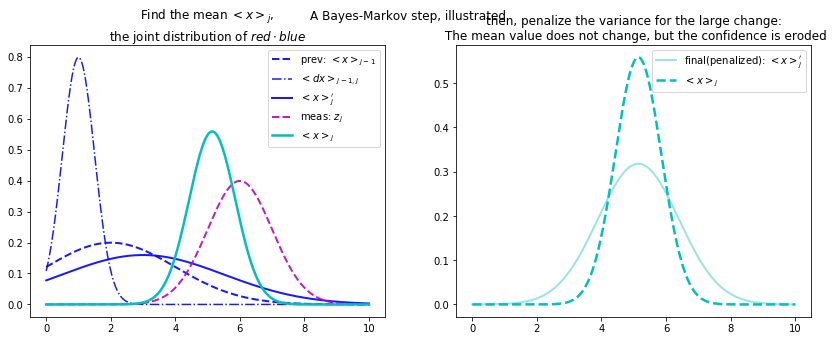

In [7]:
# make some data:

#"time":
T = numpy.linspace(0.,10, 500)
#
# (parameters of) Gauss distributions:
g_x_prev   = (2.,2.)
g_z   = (6.,1.)
g_dx = (1.,.5)
#
# now, do filter step:
# value of prev. estimate after "prediction" step:
g_x_prev_add = kalman_filters.gauss_add(g_x_prev, g_dx)
#
# new estimate:
g_x = kalman_filters.gauss_multiply(g_x_prev_add, g_z)
#
# make plottable sequences:
Ys_prev      = kalman_filters.gauss_pdf(T, *g_x_prev)                 # previous estimate (often written as "x")
Ys_dx        = kalman_filters.gauss_pdf(T, *g_dx)                     # (Predicted) change (<dx>)
Ys_prev_prime   = kalman_filters.gauss_pdf(T, *g_x_prev_add)             # revised (from predition/model) previous estimate (x')
#
Ys_z         = kalman_filters.gauss_pdf(T, *g_z)                      # measurement(s)
Ys_x         = kalman_filters.gauss_pdf(T, *g_x)                      # new best estimate, <x>
#
# now, we'll penalize large changes (aka, constrain by the Bayes-probability of a large change).
# There are 3 ways to do this:
# 1) var ~ (z_j-<x>_j): re-apply the measurement error. "yes; this is our estimate based on the measurement, but
#                      but we'd like to ammend our confidence, after the fact."
# 2) var ~ (z_j - <x>_{j-1}): what is the probability of this measured change from the previous estimate (... and it
#                           might make sense to do some additonal Bayes-Markov adjustments)
# 3) var ~ (<x>_j - <x>_{j-1}) : what are the odds of a real change in the estimated/true value?
# in the end, for a Markov sequence, the distinction between these models should be relatively small and largely show
# themselves in the form of a 1 measurement phase lag. the decision of which model to use can be made using a subjective
# optimization. For a given change, the basic model for applying the adjustment is the same.
#
scatter_factor = 1.0                         # an arbitrary factor to modify our scatter (mostly for plotting purposes)
dx_scatter = (g_x[0]-g_z[0])                # so for this model, punish an estimate far from the measured value.
var_scatter = scatter_factor*(dx_scatter**4.)/g_z[1]       # a normalized/scaled variance. here, we use the measurement variance, but
#                                                           # we could use something else (or modify our denominator)
# now, add var_scatter to estimate variance:
#g_x_prime = [g_x[0], g_x[1]+var_scatter]
g_x_prime = kalman_filters.gauss_add(g_x, [0., var_scatter])
Ys_x_prime = kalman_filters.gauss_pdf(T, *g_x_prime)
#
plt.figure(figsize=(14,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
#ax3=plt.subplot('133')
#
alph = .9
# previous estimate:
ax1.plot(T, Ys_prev, lw=2., color='b', ls='--', marker='',alpha=alph, label='prev: $<x>_{j-1}$')
ax1.plot(T, Ys_dx,  lw=1.5, color='b', ls='-.', marker='',alpha=alph, label='$<dx>_{j-1,j}$')
ax1.plot(T, Ys_prev_prime, lw=2., color='b', ls='-', marker='',alpha=alph, label='$<x>_{j}\'$')
#
# current measurement/estimate:
ax1.plot(T, Ys_z, lw=2., ls='--', marker='', color='m', alpha=alph, label='meas: $z_j$')
ax1.plot(T, Ys_x, ls='-', lw=2.5, color='c', label='$<x>_j$')
#
# now, show the large-change penalization (normalization) step:
alph = .4
ax2.plot(T, Ys_x_prime, lw=2., color='c', ls='-', marker='',alpha=alph, label='final(penalized): $<x>_{j}\'$')
ax2.plot(T, Ys_x, ls='--', lw=2.5, color='c', label='$<x>_j$')


#var_bar = .5*(g1[1] + g2[1])
#var_scatter = .005*((g1[0]-g2[0])**4.)/var_bar
#g_prev = [g_prod[0], g_prod[1]+var_scatter]
#alph=.9
#ax2.plot(T,gauss_pdf(X,*g_prev), lw=2., ls='--', marker='', color='m', alpha=alph, label='$<x>\'_j$')
#

ax1.legend(loc=0)
ax2.legend(loc=0)

plt.suptitle('A Bayes-Markov step, illustrated\n\n')
ax1.set_title('Find the mean $<x>_j$, \nthe joint distribution of $red \cdot blue$')
ax2.set_title('then, penalize the variance for the large change:\n The mean value does not change, but the confidence is eroded')

#### Above Left:
- $<x>_{j-1}$: Previous estimate (measurement and uncertainty)
- $<dx>_{j-1,j}$: Change (distribution) from $j-1$ to $j$; the "prediction" component of the Kalman Filter
- $<x>'_j$: The "primed" previous measurement; the previous measurement plus the estimated change, $<x>'_j = <x>_{j-1} + <dx>_{j-1,j}$
    - Note, it would also make sense to call this, $<x>'_{j-1} = <x>_{j-1} + <dx>_{j-1,j}$
- $z_j$: The new measured value
- $<x>_j$: The current estimate, based on $<x>'_j and <x>_j$ -- including the "prediction" step.


### A few examples:
- construct a random Fourier sequence:
  - Randomly choose some eigen-values (amplitudes) for a Fourier sequence
  - Generate a Fourier basis $\Phi_k$
  - Construct a sequence by aggregating these modes: $f(t) = \sum_k {a_k \cdot \Phi_k}$
  - Apply a Kalman filter
  - Note, because the sequence varies smoothly, we need to significantly adjust the var_b_factor and var_ba_factor values to get effective filtering.
  - Another interpretation of the above observation might that Kalman Filters are most effective for 'shot' type noise (which I think is actually a known thing), where deviations between each measurement are highly independent of one another (very weak point-to-point correlation). Nominally, this suggests a description as a low(frequency)-pass filter.
  - An interesting exercise to demonstrate this, and perhaps gain some general insight when and how Kalman filters are effective might be to interpolate the primary sequence onto a coarse x-axis (say, N/10), and maybe even add a bit of random "time-warp" fluctuation on X. This should discretize some of the higher frequencey modes and contribute to shot-like noise.

len(seq): 10000


(-0.2, 0.2)

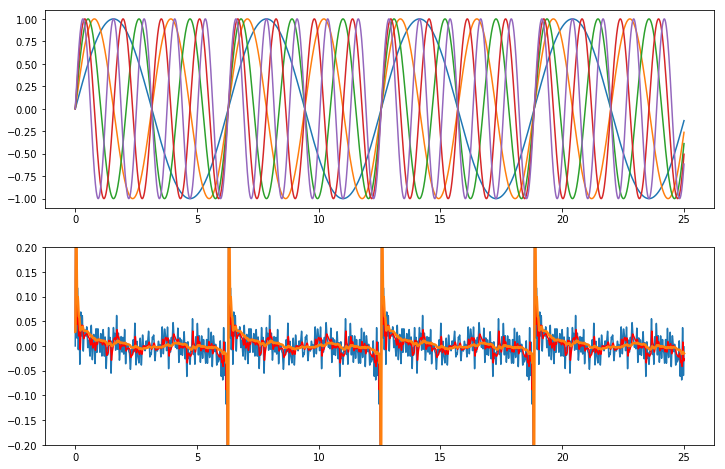

In [4]:
#
# how 'bout a demo with some fourier type data?
N_modes = 100
N_points = 10000
x_max = 25
# we might use some different distributions for this. we can for example, simulate 1/f noise by using a PL
#  distribution.
e_vals = numpy.random.uniform(size=N_modes)
#print('evals: ', e_vals)
#
X = numpy.linspace(0., x_max, N_points)
modes = [numpy.sin(X*n) for n in numpy.arange(1, N_modes+1)]
#j
# get a Kalman sequence. note Kalman_Filter inherits from List() and self-populates with [[<x>, var], ...]
seq = numpy.mean([a*mode for a,mode in zip(e_vals, modes)], axis=0)
seq_kalman = kalman_filters.Kalman_Filter(seq, var_b_factor=100., var_ba_factor=100.)
print('len(seq): {}'.format(len(seq)))
#
plt.figure(figsize=(12,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')

for mode in modes[0:5]:
    ax1.plot(X,mode)
ax2.plot(X,seq)
ax2.plot(X, kalman_filters.Kalman_Filter(seq, var_b_factor=10., var_ba_factor=10.).xs, color='r')
ax2.plot(X, seq_kalman.xs, ls='-', lw=2.5)
ax2.set_ylim(-.2, .2)
#

#### Step function example:
- Note that even for very heavy averaging (large var_b, var_ba), the filter responds quickly (compared to something simpler, like a median filter) to abrupt changes.
- We leave it to the reader, as an exercise, to demonstrate the comparison between the Kalman and Median filters.

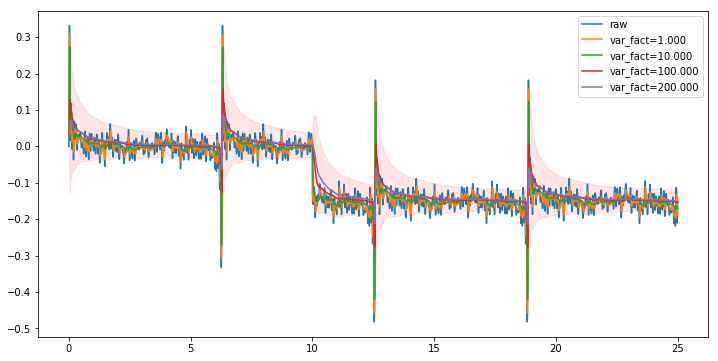

In [5]:
# a step function example:
# add a step function to our sequence above.
step_size=.15
#
seq_step = seq + numpy.array([-step_size*(k>N_points/2.5) for k in range(N_points)])

plt.figure(figsize=(12,6))
ax1 = plt.subplot('111')
#ax2 = plt.subplot('212')

ax1.plot(X, seq_step, label='raw')
for v in [1., 10., 100., 200]:
    ax1.plot(X, kalman_filters.Kalman_Filter(seq_step, var_b_factor=v, var_ba_factor=v).xs,
             label='var_fact={:.3f}'.format(v))
ax1.legend(loc=0)
#

my_seq = kalman_filters.Kalman_Filter(seq_step, var_b_factor=v, var_ba_factor=v)
ax1.fill_between(X, my_seq.xs - numpy.sqrt(my_seq.vars), my_seq.xs + numpy.sqrt(my_seq.vars),
                 alpha=.1, color='r', zorder=1)